In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('training.csv')
data.head()

,customer_id,visit_date,visit_spend
0,2,2010-04-01,5.97
1,2,2010-04-06,12.71
2,2,2010-04-07,34.52
3,2,2010-04-12,7.89
4,2,2010-04-14,17.17


In [7]:
def TopHat(x):
    return 0.5*(abs(x)<10)
def KDE(kernel, w, width, observable_points,  x):
    summ = 0
    for i in range(len(observable_points)):
        summ += w[i]*TopHat((x - observable_points[i])/width)
    return summ

In [8]:
start_train = datetime.strptime('2010-04-05', '%Y-%m-%d').date()
end_train = datetime.strptime('2011-05-29', '%Y-%m-%d').date()

In [13]:
customers = sorted(np.unique(data['customer_id']))

In [14]:
data_train = data[(data['visit_date'] < '2011-05-30') & (data['visit_date'] >= '2010-04-05')]
data_test = data[data['visit_date'] >= '2011-05-30']

За y_true взята сумма покупки в предполагаемый первый день визита из исследования Павла Лукьяненко.

In [16]:
y_true = []
y1_true = []
for client in tqdm(customers):
    cur_data = data_test[(data_test['customer_id'] == client)]
    visit = np.array(cur_data[['visit_date','visit_spend']]).T
    if visit.shape[1] > 0:
        minind = visit[0].argmin()
        first_visit = visit[0][minind]
        if (datetime.strptime(first_visit, '%Y-%m-%d').date() - end_train).days < 7:
            y_true.append(datetime.strptime(first_visit, '%Y-%m-%d').date().weekday())
            y1_true.append(visit[1][minind])
        else:
            y_true.append(-1)
            y1_true.append(-1)
    else:
        y_true.append(-1)
        y1_true.append(-1)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [03:46<00:00, 441.56it/s]


## Для каждого клиента создается два элемента: 
1. Массив всех его сумм покупок за все время в train (далее отсортированные).
2. Суммы покупок в предсказываемый день недели.

В первом из лекции - это $s_{1},...,s_{m}$, второе - $s'_{1},...,s'_{m'}$

In [18]:
customers_spend_concat = []
for client in tqdm(range(len(customers))):
    cur_data = data_train[(data_train['customer_id'] == customers[client])]
    visit = np.array(cur_data[['visit_date','visit_spend']]).T
    m_array = []
    for date in range(len(visit[0])):
        if (datetime.strptime(visit[0][date], '%Y-%m-%d').date() - start_train).days % 7 == y_true[client]:
            m_array.append(visit[1][date])
    customers_spend_concat.append([visit[1], m_array])

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [32:31<00:00, 51.25it/s]


In [19]:
for client in tqdm(range(len(customers))):
        customers_spend_concat[client][1] = set(customers_spend_concat[client][1])
        customers_spend_concat[client][0] = np.sort(customers_spend_concat[client][0])

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39062.57it/s]


Высчитывается весовая схема
$f(x) = \sum_{i = 1}^{m} \omega_{i} * K(|s_{i} - x|)$

$\omega_{i} = (1 - \beta) \frac{(m - i - 1)^\rho}{\sum_{j = 1}^{m} j^{\rho}}   \leftrightarrow  s_{i}$

$\omega_{i} = \beta \frac{(m^{'} - i - 1)^\rho1}{\sum_{j = 1}^{m'} j^{\rho^{1}}} \leftrightarrow  s'_{i}$

In [20]:
# ro1 = 1
# ro2 = 1
def predict(customers_spend_concat, beta, p0, p1):
    y1_pred = []
    s = np.sum(np.arange(len(customers))**p1)
    for client in tqdm(range(len(customers))):
        observable_points = customers_spend_concat[client][0]
        set_cust = customers_spend_concat[client][1]
        w = np.array([(1 - beta)*(len(customers) - i + 1)**p1 / s for i in range(len(observable_points))])
        k = np.sum(np.arange(len(set_cust))**p0)
        if k > 0:
            for i in range(len(observable_points)):
                if observable_points[i] in set_cust:
                    w[i] += (beta)*(len(set_cust) - i + 1)**p0 / k
        x_axis = np.arange(np.min(customers_spend_concat[client][0]), np.max(customers_spend_concat[client][0]), 3)
        res = np.array(list(map(lambda x: KDE(TopHat, w, 10, observable_points, x), x_axis)))
        y1_pred.append(x_axis[res.argmax()])
    return y1_pred

In [21]:
def score(y_true, y_pred):
    return (abs(np.array(y_true) - np.array(y_pred)) <= 10).sum() / len(y_true)

In [22]:
# x_axis[res.argmax()]

In [23]:
betas = [0, 0.2, 0.6, 0.8, 1]
res_beta = []
for i in range(len(betas)):
    res_beta.append(score(predict(customers_spend_concat, betas[i], 1,1), y1_true))
    print(betas[i], res_beta[i])

  0%|                                                                               | 9/100000 [00:00<41:49, 39.84it/s]

0 0.18823


  0%|                                                                              | 10/100000 [00:00<35:44, 46.63it/s]

0.2 0.11816


  0%|                                                                               | 6/100000 [00:00<33:19, 50.00it/s]

0.6 0.1176


  0%|                                                                              | 11/100000 [00:00<36:45, 45.34it/s]

0.8 0.11756


100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [48:22<00:00, 34.45it/s]


1 0.23579


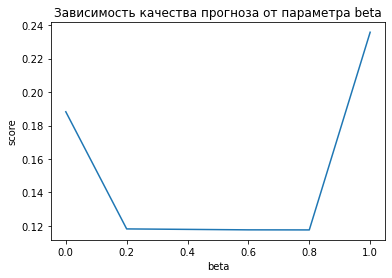

In [24]:
plt.plot(betas, res_beta)
plt.xlabel('beta')
plt.ylabel('score')
plt.title('Зависимость качества прогноза от параметра beta')
plt.show()

In [25]:
res_beta

[0.18823, 0.11816, 0.1176, 0.11756, 0.23579]

Как видно из графика, в моем случае хорошо работает при $\beta$ ,близких к нулю и к единице, то есть при использовании только данных всех сумм покупок за весь период или только сумм покупок, совершенных в угадываемый день недели.

Могу предположить, что это происходит из-за выбора predict. Было бы неплохо увеличить тестовые данные и совместить результаты на по нескольким суммам по каждому клиенту, но выполненный код очень неоптимален и демонстрирует медленную работу, что не дает выполнить дополнительные исследования